In [1]:
import numpy as np
import xarray as xr
import pyqg
from numpy.random import Generator, MT19937, SeedSequence
from pyqg import particles
import os
import yaml
import zarr

In [20]:
# ensemble member id & parameter for randomness
n = 1 #os.getenv('SLURM_ARRAY_TASK_ID') 

In [21]:
# initial conditions from equilibrium run
pickup_file = '/burg/abernathey/users/hillary/pyqg_spin_up/84672000.nc'
ds_initial = xr.open_dataset(pickup_file)

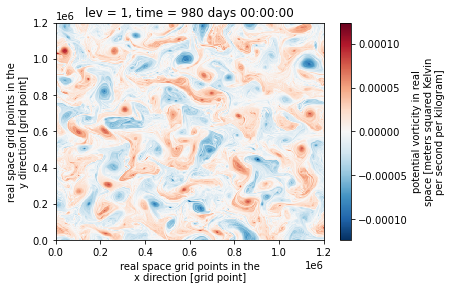

In [22]:
ds_initial.q.isel(time=0, lev=0).plot()

In [23]:
# model configuration
config_file = '/burg/home/hs3277/lcs-ml/config.yml'
with open(config_file) as file:
    config = yaml.load(file, Loader=yaml.FullLoader)

In [24]:
### One member

# configure model
m = pyqg.QGModel(nx=config['nx'], L=config['L'], dt=config['dt'], 
                 tmax=config['tmax'], twrite=config['twrite'], 
                 tavestart=config['tavestart'], ntd=config['ntd'], 
                 beta=config['beta'], rd=config['Ld'], 
                 delta=config['delta'], H1=config['H1'], 
                 U1=config['U1'], U2=config['U2'], rek=config['rek'])

# set PV anomaly with randomness
m.set_q(ds_initial.q[0,:,:,:].values) # Add noise for ensemble

INFO:  Logger initialized


In [25]:
# Set up Lagrangian particles and advect using gridded u and v
dx = m.dx/2   # or 4
dy = m.dy/2

x0,y0 = np.meshgrid(np.arange(0,m.L,dx)+dx/2,
                    np.arange(0,m.W,dy)+dy/2)

x0 = x0.ravel()
y0 = y0.ravel()

n = -1

# Lagrangian particles with velocities given on a regular cartesian grid
lpa = particles.GriddedLagrangianParticleArray2D(x0, y0, m.nx, m.ny,
        periodic_in_x=True, periodic_in_y=True,
        xmin=0, xmax=m.L, ymin=0, ymax=m.W)

### This could be replaced by asross PR `m.add_particles(initial_coords=[x0,y0])`

uprev = m.ufull[0].copy()   
vprev = m.vfull[0].copy()

Tsave =  config['day']  # daily data is saved

In [26]:
# m.tc <= model time step
# m.dt <= Numerical timestep
# m.t <= Model time 

In [ ]:
# run with snapshots, save model increments as xarray DataSet
for snapshot in m.run_with_snapshots(tsnapstart=m.t, tsnapint=m.dt):
    
    # set up velocities for Lagrangian advection
    u = m.ufull[0]
    v = m.vfull[0]

    # Advance particles using a gridded velocity field.
    lpa.step_forward_with_gridded_uv(uprev, vprev, u, v, m.dt) 

    uprev = u.copy()
    vprev = v.copy()

    if n==-1:
        qi = m.q[0].copy()
        ui = u.copy()
        vi = v.copy()

        n+=1

    # Only save daily snapshots, print numerical time step every 10 days
    if (m.t % Tsave)==0:
        if (m.t % (Tsave*10))==0:
            print(m.t, n)

        #### Vorticity 
        relative_vorticity = m.ifft(-(m.k**2 + m.l**2)*m.ph)[0]
        particle_vorticity = lpa.interpolate_gridded_scalar(lpa.x, lpa.y, relative_vorticity)

        ##### Strain 
        strain_normal = m.ifft(2 * m.k * m.l * m.ph)
        strain_shear = m.ifft((-m.k**2 + m.l**2)*m.ph)
        strain_magnitude = np.sqrt(strain_normal**2 + strain_shear**2)[0]
        particle_strain = lpa.interpolate_gridded_scalar(lpa.x, lpa.y, strain_magnitude)

        n+=1
    
        shape = (1, np.int64(m.L/dx), np.int64(m.W/dx))
        ds_particles = xr.Dataset({
            'x': (('time', 'y0', 'x0'), np.reshape(lpa.x.copy(), shape)),
            'y': (('time', 'y0', 'x0'), np.reshape(lpa.y.copy(), shape)),
            'vort': (('time', 'y0', 'x0'), np.reshape(particle_vorticity, shape)),
            'strain': (('time', 'y0', 'x0'), np.reshape(particle_strain, shape)),

            },
            coords = {
                'x0': (('x0'), np.reshape(x0, shape[1:])[0,:]),
                'y0': (('y0'), np.reshape(y0, shape[1:])[:,0]),
                'time': (('time'), np.array([m.t]))            
            }
        )    
   
        
#         fn = '/burg/abernathey/users/hillary/lpa/'+ str(ds_particles.time.values[0]) +'.nc'
#         # write to same file while appending?
#         # You can add a new variable, but you cannot add data to an existing variable without re-creating it.
#         ds_particles.to_netcdf(fn, engine='h5netcdf', invalid_netcdf=True, mode='a')

        # Save as Zarr
        fn = '/burg/abernathey/users/hillary/lpa/84672000.zarr' 
        ds_particles = ds_particles.chunk() #this uses a global chunk
        if m.t == Tsave:
            ds_particles.to_zarr(fn, mode='a', consolidated=True)
        else:
            ds_particles.to_zarr(fn, mode='a', append_dim='time', consolidated=True)
                
    if m.t==Tsave*365:
        break

864000.0 9


In [ ]:
def ensemble_generator(ds_initial, n):
    '''Save ensemble member snapshots at each time step'''
    
    # make a new directory and switch to it
    os.mkdir('/burg/abernathey/users/hillary/'+ str('%03d'%int(n)))
    os.chdir('/burg/abernathey/users/hillary/'+ str('%03d'%int(n)))
    
    # configure model
    m = pyqg.QGModel(nx=config['nx'], L=config['L'], dt=config['dt'], 
                     tmax=config['tmax'], twrite=config['twrite'], 
                     tavestart=config['tavestart'], ntd=config['ntd'], 
                     beta=config['beta'], rd=config['Ld'], 
                     delta=config['delta'], H1=config['H1'], 
                     U1=config['U1'], U2=config['U2'], rek=config['rek']) 
    
    # create an empty array filled with zeros 
    noise = np.zeros_like(ds_initial.q.values)

    # index to the middle of noise and add random perturbation to both levels
    rg = Generator(MT19937(int(n))) 
    noise[:,np.floor(len(ds_initial.x)/2).astype('int'), 
          np.floor(len(ds_initial.y)/2).astype('int')] = config['sig']*rg.random((m.q.shape[0]))

    # set PV anomaly with randomness
    m.set_q(ds_initial.q.values + noise)
    
    # Set up Lagrangian particles and advect using gridded u and v
    dx = m.dx/2   # or 4
    dy = m.dy/2

    x0,y0 = np.meshgrid(np.arange(0,m.L,dx)+dx/2,
                        np.arange(0,m.W,dy)+dy/2)
    pNy, pNx = x0.shape

    x0 = x0.ravel()
    y0 = y0.ravel()

    Npart = x0.size
    Ndays = 90 # times to integrate
    Tpart = day*Ndays # length of particle trajectory
    Tsave =  day  # daily data is saved
    Nhold = Ndays # number of days to save
    m.tmax = m.t + Tpart # let the model run some more by adding time to tmax
    
    Tstart = m.t/day
    n = -1

    particle_history = np.zeros((Nhold, 3, Npart))
    q = np.zeros([Nhold, 2, m.ny ,m.nx])
    ue = np.zeros([Nhold, m.ny, m.nx])
    ve = np.zeros([Nhold, m.ny, m.nx])
    pe = np.zeros([Nhold, m.ny, m.nx])

    lpa = particles.GriddedLagrangianParticleArray2D(x0, y0, m.nx, m.ny,
            periodic_in_x=True, periodic_in_y=True,
            xmin=0, xmax=m.L, ymin=0, ymax=m.W)

    # set up extended grid for lagrangian particles
    x = np.hstack([m.x[0,0]-m.dx, m.x[0,:], m.x[0,-1]+m.dx])
    y = np.hstack([m.y[0,0]-m.dy, m.y[:,0], m.y[-1,0]+m.dy])

    uprev = m.ufull[0].copy()   
    vprev = m.vfull[0].copy()

    
    # run with snapshots, save model increments as xarray DataSet
    for snapshot in m.run_with_snapshots(tsnapstart=m.t, tsnapint=m.dt):
        
        # set up velocities for Lagrangian advection
        u = m.ufull[0]
        v = m.vfull[0]

        lpa.step_forward_with_gridded_uv(uprev, vprev, u, v, m.dt)

        uprev = u.copy()
        vprev = v.copy()

        if n==-1:
            qi = m.q[0].copy()
            ui = u.copy()
            vi = v.copy()

            n+=1

        if (m.t % Tsave)==0:
            if (m.t*(Tsave*10))==0:
                print(m.t, n)

            # calculate relative vorticity using PV anomaly
            p = m.ifft(m.ph)
            vort = m.q[0] - m.F1*(p[1]-p[0])

            # vorticty on particles
            pvort = lpa.interpolate_gridded_scalar(lpa.x, lpa.y, vort)

            particle_history = np.roll(particle_history, 1, axis=0)
            particle_history[0,0] = lpa.x
            particle_history[0,1] = lpa.y
            particle_history[0,2] = pvort
            # time goes backwards in particle history

            q = np.roll(q, 1, axis=0)
            q[0] = m.q
            ue = np.roll(ue, 1, axis=0)
            ue[0] = m.u[0]
            ve = np.roll(ve, 1, axis=0)
            ve[0] = m.v[0]
            pe = np.roll(pe, 1, axis=0)
            pe[0] = p[0]

            n+=1
        
        model = m.to_dataset()
        model = model.expand_dims(dim='n') # ensemble member n
        model['n'] = [int(n)]

        fn = '/burg/abernathey/users/hillary/'+ str('%03d'%int(n)) +'/QG_lcs_EM_'+ str('%03d_%08d'%(int(n),model.time.values[0])) +'.nc'
        model.to_netcdf(fn, engine='h5netcdf', invalid_netcdf=True, mode='a')



In [ ]:
# generate ensemble
ensemble_generator(ds_initial, n)